In [1]:
import shnitsel as sh
import shnitsel.xarray
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load data

In [2]:
# TODO
A02 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C3H6.nc')
A03 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C4H8_g0.nc')

# This isn't necessary for this notebook in its current state
A02 = A02.isel(atom=slice(0,6)).assign_coords(atom=[0, 1, 2, 3, 5, 4]).sortby('atom')
A03 = A03.isel(atom=[0,1,2,3,7,8]).assign_coords(atom=[3, 1, 0, 2, 4, 5]).sortby('atom')

# Filter cleavages
A02.atXYZ.attrs['smiles_map'] = A02.atXYZ.isel(frame=0).sh.smiles_map(charge=-3)
A03.atXYZ.attrs['smiles_map'] = A03.atXYZ.isel(frame=0).sh.smiles_map(charge=-8)
filtration_verbosity = 0
A02 = sh.dynamic.filter_unphysical.filter_cleavage(A02, CC=True, CH=True, verbose=filtration_verbosity)
A03 = sh.dynamic.filter_unphysical.filter_cleavage(A03, CC=True, CH=True, verbose=filtration_verbosity)

# Calculate dihedrals & cluster

In [3]:
dih = A03.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True)
dih['e_pot'] = A03.energy.sel(state=A03.astate).drop_vars('state')
dih['astate'] = A03.astate

In [4]:
end_dih = dih.groupby('trajid').last()
end_dih['ZZ'] = end_dih<80
end_dih['ZE'] = end_dih>100

trajids_ZZ = end_dih.trajid[end_dih['ZZ']]
ZZ = A03.sh.sel_trajs(trajids_ZZ)

trajids_ZE = end_dih.trajid[end_dih['ZE']]
ZE = A03.sh.sel_trajs(trajids_ZE)

# Plot populations

In [5]:
import numpy as np

def _plot_pops(pops, ax=None, c='k'):
    if ax is None:
        _, ax = plt.subplots(1,1)
    for state, sdata in pops.groupby('state'):
        ls = sdata['_ls'].item()
        ax.plot(sdata['time'], sdata, c=c, ls=ls)
    ax.set_ylabel('Population')
    ax.set_xlabel('$t$ / fs')
    return ax
    
def pops_combine(frames, ax=None, c='k'):
    if ax is None:
        _, ax = plt.subplots(1,1)
    pops = frames.sh.calc_pops()
    combined = xr.DataArray(
        np.c_[pops[:, 0], pops[:, [1, 2]].sum('state')],
        coords=[pops.time, ('state', [s[1] for s in COMBINED_STATES])]
    )
    combined['_ls'] = 'state', [s[0] for s in COMBINED_STATES]
    _plot_pops(combined, ax, c=c)
    return ax


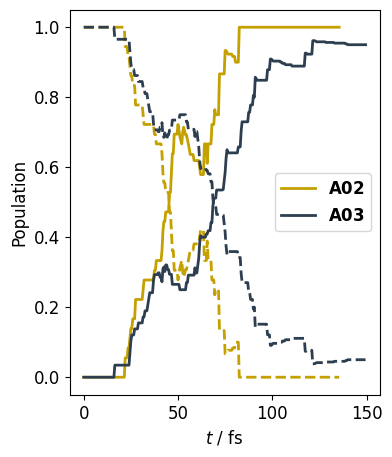

In [17]:
from matplotlib.lines import Line2D

ensembles = [
    # (A03, '#7E5273', r'$\mathbf{A03}$ (all)'),
    # (ZZ, '#2c3e50', r'$\mathbf{A03}$ ($Z\rightarrow Z$)'),
    (A02, '#C4A000', r'$\mathbf{A02}$'),
    (ZZ, '#2c3e50', r'$\mathbf{A03}$'),
    # (ZE, '#999', r'$\mathbf{A03}$ ($Z\rightarrow E$)'),
]

COMBINED_STATES = [
    ('-', '$S_0$'),
    ('--', '$S_1$ & $S_2$')
]

def leg(label, **kwargs):
    return Line2D([0], [0], label=label, **kwargs)

linestyles = [leg(lb, c='k', ls=ls) for ls, lb in COMBINED_STATES]
colours = [leg(lb, c=c, ls='-') for _, c, lb in ensembles]

plt.rc('font', size=12)
plt.rc('lines', linewidth=2)

fig, ax = plt.subplots()
fig.set_size_inches(4, 5)
for data, c, lb in ensembles:
    pops_combine(data, ax, c=c)
handles = colours
# handles = linestyles + colours
ax.legend(handles=handles, loc='center right')